In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/ .kaggle/kaggle.json
!kaggle datasets download -d rajkumar/people-clothing-segmentation

In [ ]:
!unzip "dataset.zip" -d "outputpath"

In [ ]:
!pip install diffusers

In [2]:
import os
import shutil
import numpy as np
#from difusers import StableDiffusionInpaintPipline
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
import fiftyone as fo
from transformers import AutoImageProcessor, TFSegformerForSemanticSegmentation, KerasMetricCallback
#from transformers.keras.callbacks import KerasMetricCallback
from PIL import Image
import requests
import pandas as pd
#import evaluate

C:\Users\hamid\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\hamid\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
data = pd.read_csv("labels.csv")
data.head()

,Unnamed: 0,label_list
0,0,NaN
1,1,accessories
2,2,bag
3,3,belt
4,4,blazer


In [4]:
id2label = {}
for i, j in data.iterrows():
    if i ==0:
        id2label[i] = "non"

    else:
        id2label[i] = j["label_list"]

#id2label

In [5]:
label2id = {label:id for id, label in id2label.items()}
len(label2id)

59

In [6]:
#model_id = "nvidia/segformer-b0-finetuned-ade-512-512"
model_id = "nvidia/segformer-b5-finetuned-ade-640-640"

model = TFSegformerForSemanticSegmentation.from_pretrained(model_id,
                                                          num_labels=len(id2label),
                                                          id2label=id2label,
                                                          label2id=label2id,
                                                          ignore_mismatched_sizes=True)

All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

Some weights of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b5-finetuned-ade-640-640 and are newly initialized because the shapes did not match:
- decode_head/classifier/kernel:0: found shape (1, 1, 768, 150) in the checkpoint and (1, 1, 768, 59) in the model instantiated
- decode_head/classifier/bias:0: found shape (150,) in the checkpoint and (59,) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
model.summary()

Model: "tf_segformer_for_semantic_segmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  81443008  
 Layer)                                                          
                                                                 
 decode_head (TFSegformerDe  multiple                  3197243   
 codeHead)                                                       
                                                                 
Total params: 84640251 (322.88 MB)
Trainable params: 84638715 (322.87 MB)
Non-trainable params: 1536 (6.00 KB)
_________________________________________________________________


In [6]:
H, W = 512, 512

In [8]:
model(tf.zeros([1, 3, H, W])).logits.shape

NameError: name 'model' is not defined

In [9]:
images_path = "people cloth segmentation"

In [10]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [5]:
# create_dir(images_path + "\\val_dataset")
# create_dir(images_path + "\\val_dataset" + "\\png_images")
# create_dir(images_path + "\\val_dataset" + "\\png_masks")

In [11]:
val_list = [
    "0100", "0115", "0025", "0018", "0003", "0125", "0200", "0515", "0225", "0805", "0915", "0630", "0301", "0122", "0905", "0823", "0527", "0088", "0055", "0077", 
    "0222", "0049", "0273", "0299", "0282", "0372", "0027", "0445", "0582", "0374", "0956", "0211", "0019", "0961", "0397", "0699", "0789", "0996", "0290", 
    "0110", "0315", "0335", "0419", "0666", "0525", "0927", "0555", "0275", "0855", "0815", "0130", "0371", "0412", "0105", "0423", "0507", "0028", "0035", "0066", 
    "0232", "0849", "0673", "0688", "0777", "0472", "0991", "0485", "0592", "0334", "0827", "0651", "0619", "0567", "0393", "0609", "0719", "0916", "0190"
]

In [7]:
# for name in val_list:
#     shutil.move(images_path + "\\png_images" + "\\IMAGES\\" + "img_" + name + ".png",
#                 images_path + "\\val_dataset" + "\\png_images\\" + "img_" + name + ".png")
    
#     shutil.move(images_path + "\\png_masks\\MASKS\\" + "seg_" + name + ".png",
#                 images_path + "\\val_dataset\\png_masks\\" + "seg_" + name + ".png")

In [8]:
# for i in os.listdir(images_path + "\\png_masks\\MASKS\\"):
#     #print(i)
#     #break
#     os.rename(images_path + "\\png_masks\\MASKS\\" + i, images_path + "\\png_masks\\MASKS\\" + "img" + i[3:])

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    ([images_path + "\\png_images\\IMAGES\\" + i for i in os.listdir(images_path + "\\png_images\\IMAGES")],
    [images_path + "\\png_masks\\MASKS\\" + i for i in os.listdir(images_path + "\\png_masks\\MASKS")])
)

val_dataset = tf.data.Dataset.from_tensor_slices(
    ([images_path + "\\val_dataset\\png_images\\" + i for i in os.listdir(images_path + "\\val_dataset\\png_images")],
    [images_path + "\\val_dataset\\png_masks\\" + i for i in os.listdir(images_path + "\\val_dataset\\png_masks")])
)

In [15]:
for i in train_dataset.take(1):
    print(i)

for i in val_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'E:\\python\\segmentation\\Computer Vision\\Deploying Custom yolo on cloud\\Data\\people cloth segmentation\\png_images\\IMAGES\\img_0001.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'E:\\python\\segmentation\\Computer Vision\\Deploying Custom yolo on cloud\\Data\\people cloth segmentation\\png_masks\\MASKS\\img_0001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'E:\\python\\segmentation\\Computer Vision\\Deploying Custom yolo on cloud\\Data\\people cloth segmentation\\val_dataset\\png_images\\img_0003.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'E:\\python\\segmentation\\Computer Vision\\Deploying Custom yolo on cloud\\Data\\people cloth segmentation\\val_dataset\\png_masks\\seg_0003.png'>)


In [16]:
len(train_dataset), len(val_dataset)

(922, 78)

In [17]:
mean = [123.675, 116.28, 103.53] # obtained from imagenet dataset
std = [58.395, 57.12, 57.375] 

In [18]:
def preprocessing(img_path, mask_path):
    img = tf.io.decode_jpeg(tf.io.read_file(img_path))
    img = tf.cast(img, tf.float32)
    img = (img - mean) / std

    mask = tf.io.decode_jpeg(tf.io.read_file(mask_path))
    mask = tf.cast(tf.squeeze(mask, -1), tf.float32)

    return img, mask

In [19]:
images_data_path = "IMAGES"
mask_data_path = "MASKS"

val_image_path = "png_images"
val_mask_path = "png_masks"

In [20]:
prep_train_dataset = (
    train_dataset
    .shuffle(10)
    .map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
)

prep_val_dataset = (
    val_dataset
    .map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
)

In [21]:
for i, j in prep_train_dataset.take(1):
    print(i.shape, j.shape)
    break

(825, 550, 3) (825, 550)


In [22]:
transform = A.Compose([
    A.RandomCrop(H, W, p=1.0),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.3),
    A.Transpose(p=0.3),
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5),
    A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), 
                  num_shadows_lower=1, num_shadows_upper=2,
                  shadow_dimension=5, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    #A.Resize(H, W),
])

val_transform = A.Compose([
    A.Resize(H, W),
])

Data Augmentation 

In [23]:
def tf_dataset_for_train(image, mask):
    
    def aug_albument(image, mask):
        augmented = transform(image=image, mask=mask)
        return [tf.convert_to_tensor(augmented["image"], dtype=tf.float32),
               tf.convert_to_tensor(augmented["mask"], dtype=tf.float32)]
    
    aug_output = tf.numpy_function(func=aug_albument, inp=[image, mask], Tout=[tf.float32, tf.float32])

    return {"Pixel values" :tf.transpose(aug_output[0],(2, 0, 1)), "Labels":aug_output[1]}

In [24]:
def tf_dataset_for_val(image, mask):
    
    def val_aug_transform(image, mask):
        augmented = val_transform(image=image, mask=mask)
        return [tf.convert_to_tensor(augmented["image"], dtype=tf.float32),
               tf.convert_to_tensor(augmented["mask"], dtype=tf.float32)]

    aug_output = tf.numpy_function(func=val_aug_transform, inp=[image, mask], Tout=[tf.float32, tf.float32])

    return {"Pixel values":tf.transpose(aug_output[0], (2, 0, 1)), "Labels":aug_output[1]}

In [25]:
BATCH_SIZE = 32

In [26]:
train_dataset = (
    prep_train_dataset
    .shuffle(10)
    .map(tf_dataset_for_train, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    prep_val_dataset
    .map(tf_dataset_for_val, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [27]:
for i in train_dataset.take(1):
    print(i)

{'Pixel values': <tf.Tensor: shape=(32, 3, 512, 512), dtype=float32, numpy=
array([[[[ 0.37643114,  0.46572   ,  0.38113055, ...,  1.        ,
           1.        ,  1.        ],
         [ 0.44692233,  0.46102056,  0.34353524, ...,  1.        ,
           1.        ,  1.        ],
         [ 0.329437  ,  0.27774346,  0.20255287, ...,  0.94506013,
           1.        ,  0.11796343],
         ...,
         [ 0.7429854 ,  0.15555874,  0.40462762, ...,  0.6067024 ,
           0.88396776,  0.22135052],
         [ 1.        ,  0.6114018 ,  0.51741356, ...,  0.72888714,
           1.        ,  0.5268124 ],
         [ 0.73828596,  0.24014817,  0.09916578, ...,  1.        ,
           0.09916578,  0.75238425]],

        [[ 0.54561   ,  0.6348989 ,  0.6067024 , ...,  1.        ,
           1.        ,  1.        ],
         [ 0.6114018 ,  0.63019943,  0.5691071 , ...,  1.        ,
           1.        ,  0.16025814],
         [ 0.49861586,  0.44222292,  0.4281247 , ...,  1.        ,
         

Data Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


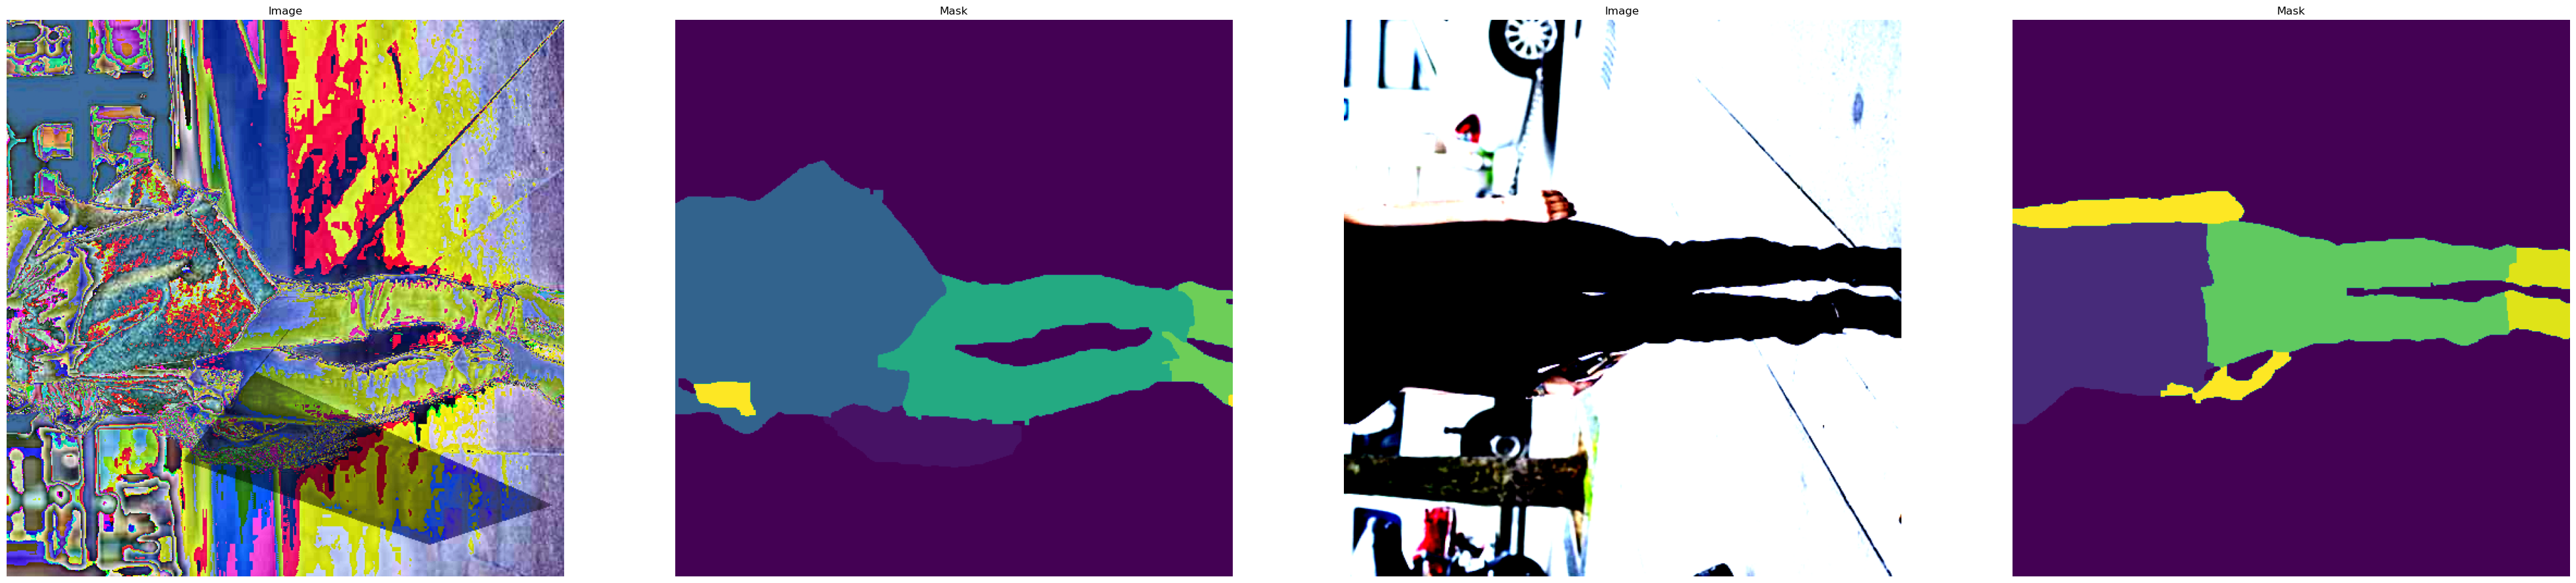

In [23]:
plt.figure(figsize=(50, 50))

for data in train_dataset.take(1):
    images = data["Pixel values"]
    labels = data["Labels"]

    for i in range(4):
        if i ==4:
            break
            
        ax = plt.subplot(1, 4, i+1)

        if i % 2 ==0:
            plt.imshow(tf.transpose(images[i//2], (1, 2, 0)))
            plt.title("Image")

        else:
            plt.imshow(labels[i//2])
            plt.title("Mask")

        plt.axis("off")

    plt.show()

In [31]:
import fiftyone as fo

name = "clothing-dataset1"
dataset_dir = images_path + "\\png_images\\IMAGES"
labels_dir = images_path + "\\png_masks\\MASKS"

# Create the dataset 
dataset = fo.Dataset.from_dir(
    data_path=dataset_dir,
    labels_path = labels_dir,
    dataset_type=fo.types.ImageSegmentationDirectory,
    name=name
)

# View summary info about the dataset
print(dataset)

# Print the first few samples in the dataset
print(dataset.head())

ServerSelectionTimeoutError: localhost:56791: [WinError 10061] No connection could be made because the target machine actively refused it (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms), Timeout: 30s, Topology Description: <TopologyDescription id: 662496304d1c5b45a114bf40, topology_type: Single, servers: [<ServerDescription ('localhost', 56791) server_type: Unknown, rtt: None, error=AutoReconnect('localhost:56791: [WinError 10061] No connection could be made because the target machine actively refused it (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms)')>]>

Training And Evaluation

In [ ]:
metric = evaluate.load("mean_iou")

In [28]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = tf.transpose(logits, prem=[0, 2, 3, 1])
    logits_resized = tf.image.resize(
        logits,
        size=tf.shape(labels)[1:],
        method="bilinear"
    )
    pred_labels = tf.argmax(logits_resized, axis=-1)
    metrics = metric.compute(
        predictions = pred_labels,
        references = labels,
        num_labels = num_labels,
        ignore_index = -1
    )

    pred_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    pred_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(pred_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(pred_category_iou)})

    return {"val_" + k: v for k, v in metrics.items()}

In [30]:
batch_size = 2
num_epochs = 15
num_train_steps = len(train_dataset) * num_epochs
learning_rate = 6e-5
weight_decay_rate = 0.01

metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics,
    eval_dataset=val_dataset,
    batch_size=batch_size,
    label_cols=["labels"]
)

callbacks = [metric_callback]

optimizer, lr_shedule = create_optimizer(
    init_lr = learning_rate,
    num_train_steps = num_train_steps,
    weight_decay_rate = weight_decay_rate,
    num_warmup_steps=0,
)

NameError: name 'create_optimizer' is not defined

In [ ]:
model.compile(optimizer=optimizer)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=num_epochs,
    callbacks=callbacks
)

In [ ]:
checkpoint_file_path = "segformer_b5.clothing.h5"
model.save_weights(checkpoint_file_path)

Evaluation with Fiftyone

In [34]:
dataset.head()

NameError: name 'dataset' is not defined

In [ ]:
for i, sample in enumerate(dataset):
    img = tf.io.decode_jpeg(tf.io.read_file(sample.filepath))
    img = tf.image.resize(img, (H, W))
    img = tf.cast(img, tf.float32)
    img = (img - mean) / std
    img = tf.transpose(img, (2, 0, 1))
    img = tf.expand_dims(img, axis=0)

    output = model(img).logits
    output = tf.argmax(output, axis=1)

    resized_output = tf.image.resize(tf.expand_dims(output, axis=-1), (H, W),
                                     method="bilinear", antialias=True)

    resized_output tf.cast(tf.squeeze(resized_output, axis=-1), dtype=uint8)[0]

    sample["pred"] = fo.Segmentation(mask=resized_output.numpy)

    mask = cv2.imread(sample["ground_truth"]["mask_path"], cv2.IMREAD_GRAYSCALE)
    metrics = metric.compute(
        prediction = [resized_output.numpy()],
        reference = [mask],
        num_labels = len(label2id),
        ignore_index = 0,
        nan_to_num = 0,
        reduce_labels = False
    )

    sample["mean_iou"] = metrics["mean_iou"]
    sample["mean_accuracy"] = metrics["mean_accuracy"]
    sample["overall_accuracy"] = metrics["overall_accuracy"]

    for k,c in enumerate(metric["per_category_iou"]):
        if c > 0.001:
            key = id2label[i] + "_iou" ## e.g. shoes_iou
            sample["ket"] = c
    
    sample.save()
    if i > 5:
        break

In [ ]:
model(tf.ones([1, 3, 512, 512])).logits.shape

Viz

In [ ]:
dataset.default_mask_target = id2label
session = fo.launch_app(dataset)

In [ ]:
dataset.head()

Generating New Samples

In [38]:
def generate_inputs(img_path, mask_label):
    mask = label2id[mask_label]
    source_img = cv2.imread(img_path)
    #mask = model(source_img)

    img = tf.io.decode_jpeg(tf.io.read_file(img_path))
    img = tf.image.resize(img, (H, W))
    img = tf.cast(img, tf.float32)
    img = (img - mean) / std
    img = tf.transpose(img, (2, 0, 1))
    img = tf.expand_dims(img, axis=0)

    output = model(img).logits

    output = tf.argmax(output, axis=1)

    resized_output = tf.image.resize(
        tf.expand_dims(output, axis=1), (H, W), method="bilinear",
        antialias=True,
    )

    resized_output = tf.cast(tf.squeeze(resized_output, axis=-1), dtype=tf.uint8)[0].numpy()

    mask = resized_output + (-mask_id * np.ones_like(resized_output))
    mask = np.clip(1e10 * np.multiply(mask, mask), a_min=0, a_max=255)

    cv2.imwrite("mask.jpg", mask)
    
    return Image.fromarray(source_img), Image.fromarray(resized_output)

In [39]:
generate_inputs(img_path)

NameError: name 'img_path' is not defined

In [ ]:
pipe = StableDiffusionInpaintPipline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype = torch.float16,
)

pipe.to("cuda")
pipe.enable_xformes_memory_efficient_attention()

In [ ]:
prompt = "A photorealistic of a women wearing a green color nice looking coat, high resolution"

iamge, mask_image = generate_inputs(img_path, "coat")

pipe.enable_xformes_memory_efficient_attention()
image = pipe(prompt=prompt, image=image, mask_image=mask_image)
image.resize(W, H)
display(image)
#image.save("./coat.png")

Data Augmentation

In [ ]:
model_id = "stabilityai/stable.diffusion-2-inpainyin"

In [12]:
def create_pipeline(model_id):
    scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
    pipe = StableDiffusionInpaintPipeline.from_pretrained(model_id,
                                                         scheduler=scheduler,
                                                         revision="fp16",
                                                         torch_dtype=torch.float16)
    pipe = pipe.to("cuda")
    pipe.enable_xfroemers_memort_efficient_attention()
    return pipe

In [13]:
def generate_inputs(im_path, mask_path, mask_id):
    source_image = cv2.imread(im_path)
    sd_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    out = (sd_mask + (-mask_id * np.ones_like(sd_mask)))
    mask = -(np.clip(1e10 * np.multiply(out, out), a_min=0, a_max=255) - 255)

    pil_image = Image.fromarray(source_image).resize((512, 512))
    pil_mask = Image.fromarray(mask).resize((512, 512))
    return pil_image, pil_mask

In [15]:
def augpaint(pipe, prompt, pil_image, pil_mask, guidance_scale, num_inference_step):
    num_images_per_prompt = 1
    generator = torch.Generator(device="cuda").manual_seed(10)

    encoded_images = []

    for i in range(num_images_per_prompt):
        image = pipe(prompt=prompt, guidance_scale=guidance_scale,
                    num_inference_steps = num_inference_step, generator=generator,
                    image=pil_image, mask_image=pil_mask).images[0]
        encoded_images.append(image.resize((550, 825)))

    return encoded_images[0]

In [18]:
import random
def create_hash():
    randint = random.randint(0, 100000000)
    hash = hashlib.sha256(str(randint).encode("utf-8")).hexdigest()[:10]
    return hash

In [19]:
create_hash()

NameError: name 'hashlib' is not defined

In [20]:
def list_classes(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    list_unique = np.unique(mask)
    return list_unique

In [ ]:
guidance_scale = 17.5
num_inference_steps = 50

val_im_path = "/content/val_dataset/pnp_images/IMAGES/"
val_anno_path = "/content/val_dataset/pnp_images/MASKS/"

In [22]:
def transform_sample(sample, select_class, prompt):
    hash = creat_hash()
    filename = sample.filename.split("/")[-1][:-4] + "_" + str(hash) + ".png"
    pipe = create_pipeline(model_id)
    #print(list_classes(sample.ground_truth.mask_path))
    im, mask = generate_inputs(
        sample.filepath, sample.ground_truth.mask_path,
        label2id[select_class]
    )
    #cv2.imwrite(val_im_Path + filename, np.array(im))
    out = augpaint(pipe, prompt, im, mask, guidance_scale, num_inference_step)
    print(np.array(out).shape)
    #cv2.imwrite(sample.filepath[:-4] + "_" + str(hash) + ".png",
               #np.array(out))

    im_save = out.save(sample.filepath[:-4] + "_" + str(hash) + "_" + str(i) + ".png")

    shutil.copy(sample.ground_truth.mask_path,
               sample.ground_truth.mask_path[:-4] + "_" + str(hash) + ".png")

    display(out)

    new_sample = fo.Sample(
        file_path = sample.filepath[:-4] + "_" + str(hash) + ".png",
        ground_truth = fo.Segmentation(
            mask_path=ssample.ground_truth.mask_path[:-4] + "_" + str(hash) + ".png"
        ),
    )

    return new_sample

In [ ]:
for sample in dataset:
    if sample.id = "65d4f30c067ab85dccldff47""
        new_sample = transform_sample(sample, "coat", "A photorealistic photo of a woman wearing a green coat")
        dataset.add_sample(new_sample)
    #break

In [ ]:
for sample in dataset:
    new_sample = transform_sample(sample, "coat", "A photorealistic photo of a woman wearing a green coat")
    dataset.add_sample(new_sample)
    print(sample.filepath)
    print(sample.ground_truth.mask.path)
    break

In [ ]:
dataset.tail()

In [ ]:
dataset.default_mask_targets = label2id
session = fo.launch_app(dataset, port=51)